In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers 
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [25]:
BUCKET = 21
IMAGE_SIZE = (256, 256)
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128

In [26]:
gdrive_dir = "/content/drive/MyDrive"
working_dir = os.path.join(gdrive_dir, "NUS/CS3244/CS3244 Project")
data_root_dir = os.path.join(working_dir, "landmarks/international/data_split")
data_dir = os.path.join(data_root_dir, str(BUCKET))
model_root_dir = os.path.join(working_dir, "models/Pinxi")

In [27]:
print('number of international labels:', len(os.listdir(data_dir)))

number of international labels: 200


In [28]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255, 
    validation_split = VALIDATION_SPLIT,
    rotation_range = 30,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.1,
    brightness_range = [0.9,1.1],
    fill_mode = 'nearest'
)
train_generator = train_datagen.flow_from_directory(
    data_dir,
    subset = "training", 
    shuffle = True, 
    target_size = IMAGE_SIZE ,
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
)

validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split = VALIDATION_SPLIT
)
validation_generator = validation_datagen.flow_from_directory(
    data_dir,
    subset = "validation", 
    shuffle = False, 
    target_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = 'categorical'
)

Found 1500 images belonging to 200 classes.
Found 290 images belonging to 200 classes.


In [ ]:
incept_model = InceptionV3(
    input_shape = IMAGE_SIZE + (3,),
    include_top = False
)

87916544/87910968 [==============================] - 0s 0us/step


In [ ]:
incept_model.summary()

In [ ]:
last_layer = incept_model.get_layer("mixed9_1")
last_output = last_layer.output

In [ ]:
x = layers.Flatten()(last_output)
x = layers.BatchNormalization(name='batch_normalization_output_1')(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization(name='batch_normalization_output_2')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(200, activation='softmax')(x)

model = Model(incept_model.input, x)

In [ ]:
model.summary()

In [ ]:
save_model_dir = os.path.join(model_root_dir, "inceptionv3_model_iB")
model.save(save_model_dir)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/NUS/CS3244/CS3244 Project/models/Pinxi/inceptionv3_model_iB/assets


In [7]:
load_model_dir = os.path.join(model_root_dir, "inceptionv3_model_iA17t0b20")
model = tf.keras.models.load_model(load_model_dir)

In [29]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(lr=0.001),
    metrics = ['accuracy']
)

steps_per_epoch = int(train_generator.samples / BATCH_SIZE)
validation_steps = int(validation_generator.samples / BATCH_SIZE)

print("Steps per epoch:", steps_per_epoch)
print("Validation steps:", validation_steps)

Steps per epoch: 11
Validation steps: 2


In [30]:
history = model.fit(
    train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs = 20,
    validation_data = validation_generator,
    validation_steps = validation_steps
)

save_model_dir = os.path.join(model_root_dir, "inceptionv3_model_iA21t0b20")
model.save(save_model_dir)

df = pd.DataFrame(history.history)
hist_dir = os.path.join(model_root_dir, "history/inceptionv3_model_iA21t0b20.csv")
df.to_csv(hist_dir)

Epoch 1/20
11/11 [==============================] - 434s 42s/step - loss: 7.4712 - accuracy: 0.0512 - val_loss: 3.7984 - val_accuracy: 0.3281
Epoch 2/20
11/11 [==============================] - 79s 7s/step - loss: 2.7858 - accuracy: 0.4561 - val_loss: 2.9255 - val_accuracy: 0.4648
Epoch 3/20
11/11 [==============================] - 78s 7s/step - loss: 1.6190 - accuracy: 0.6431 - val_loss: 2.5198 - val_accuracy: 0.5039
Epoch 4/20
11/11 [==============================] - 78s 7s/step - loss: 1.0962 - accuracy: 0.7503 - val_loss: 1.7298 - val_accuracy: 0.6445
Epoch 5/20
11/11 [==============================] - 78s 7s/step - loss: 0.6917 - accuracy: 0.8465 - val_loss: 1.6000 - val_accuracy: 0.6562
Epoch 6/20
11/11 [==============================] - 78s 7s/step - loss: 0.4090 - accuracy: 0.9022 - val_loss: 1.4399 - val_accuracy: 0.6953
Epoch 7/20
11/11 [==============================] - 78s 7s/step - loss: 0.2447 - accuracy: 0.9542 - val_loss: 1.4655 - val_accuracy: 0.6992
Epoch 8/20
11/11 [

<Figure size 432x288 with 0 Axes>

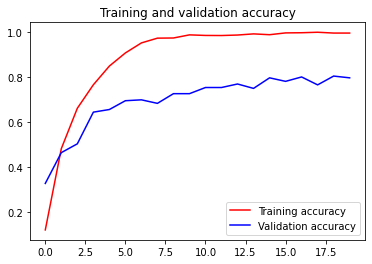

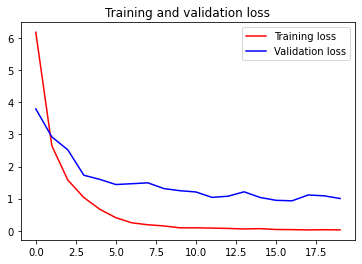

<Figure size 432x288 with 0 Axes>

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()